In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

In [ ]:
seed = 2
np.random.seed(seed)
torch.manual_seed(seed)
%matplotlib inline

In [3]:
df = pd.read_csv('data/Iris.csv')

In [4]:
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
labels = set(df['Species'].copy())
print(labels)
labels = {l:i for i, l in enumerate(labels)}
print(labels)

{'Iris-virginica', 'Iris-setosa', 'Iris-versicolor'}
{'Iris-virginica': 0, 'Iris-setosa': 1, 'Iris-versicolor': 2}


In [6]:
df['Species'] = [labels[l] for l in df['Species']]

In [7]:
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,1
1,2,4.9,3.0,1.4,0.2,1
2,3,4.7,3.2,1.3,0.2,1
3,4,4.6,3.1,1.5,0.2,1
4,5,5.0,3.6,1.4,0.2,1


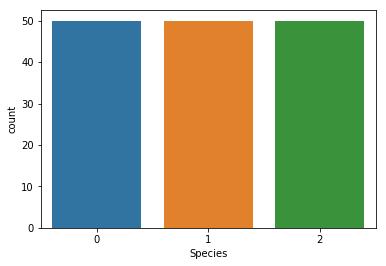

In [8]:
sns.countplot(df['Species'])

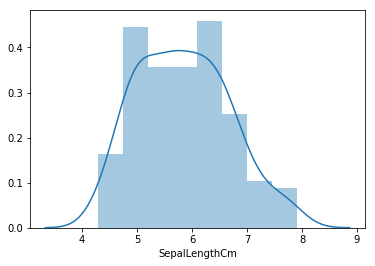

In [9]:
sns.distplot(df['SepalLengthCm'])

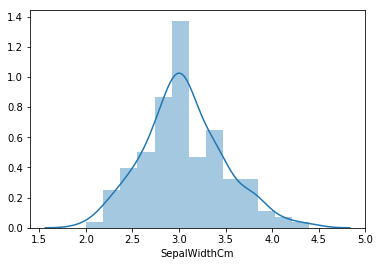

In [10]:
sns.distplot(df['SepalWidthCm'])

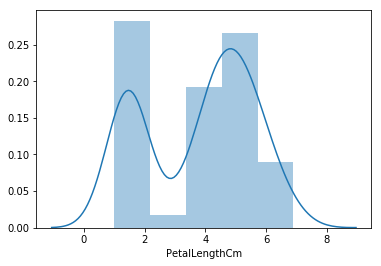

In [11]:
sns.distplot(df['PetalLengthCm'])

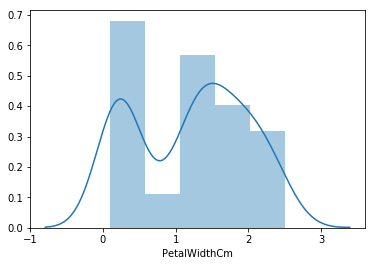

In [12]:
sns.distplot(df['PetalWidthCm'])

In [13]:
X, y = df[['SepalLengthCm','SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']],df['Species']

In [14]:
X = StandardScaler().fit_transform(X)

In [15]:
df_X = pd.DataFrame(X, columns=['SepalLengthCm','SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'])

In [16]:
df_X.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,-0.900681,1.032057,-1.341272,-1.312977
1,-1.143017,-0.124958,-1.341272,-1.312977
2,-1.385353,0.337848,-1.398138,-1.312977
3,-1.506521,0.106445,-1.284407,-1.312977
4,-1.021849,1.263460,-1.341272,-1.312977


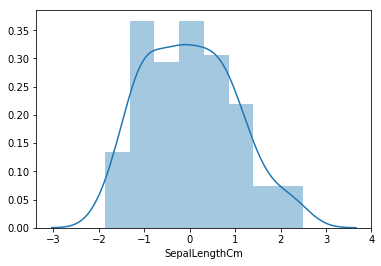

In [17]:
sns.distplot(df_X['SepalLengthCm'])

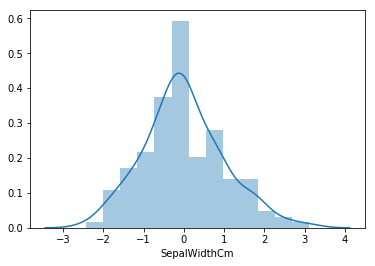

In [18]:
sns.distplot(df_X['SepalWidthCm'])

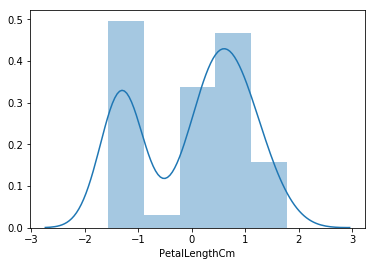

In [19]:
sns.distplot(df_X['PetalLengthCm'])

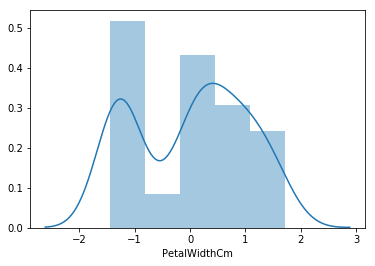

In [20]:
sns.distplot(df_X['PetalWidthCm'])

In [30]:
y_hot = np.zeros((y.shape[0], 3))
for row, l in zip(y_hot, y):
    row[l] = 1

In [32]:
X, y = shuffle(df_X, y_hot)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [33]:
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(120, 4) (120, 3)
(30, 4) (30, 3)


In [38]:
train_X, test_X = train_X.values, test_X.values

In [39]:
class Dataset(data.Dataset):
    def __init__(self, samples, labels):
        self.X = samples
        self.y = labels
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [40]:
train_dataset = Dataset(train_X, train_y)
test_dataset = Dataset(test_X, test_y)

In [99]:
n_iters = 5000
batch_size = 32
n_epochs = n_iters / (len(train_dataset)/batch_size)
n_epochs = int(n_epochs)

In [42]:
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size, shuffle=False)

In [155]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_layer_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_layer_dim)
        self.relu = nn.ReLU()
        self.linear_out = nn.Linear(hidden_layer_dim, output_dim)
    
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear_out(out)
        return out

In [156]:
model = LogisticRegressionModel(4, 100, 3)

In [157]:
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

In [158]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [159]:
train_loss = []
counter = 0
for epoch in range(n_epochs):
    for i, (X, y) in enumerate(train_loader):
        # Load the data into pytorch variables
        X = Variable(X.float())
        y = Variable(y.float())
        
        # clear the optimizer's buffer
        optimizer.zero_grad()
        
        # forward operation
        outputs = model(X)
#         print(outputs.size(), y.size())
        
        # calculate loss
#         loss = criterion(outputs, torch.max(y,1)[1])
        loss = criterion(outputs, y)
        train_loss.append(loss)
        
        # backward operation
        loss.backward()
        
        # update weights
        optimizer.step()
        
        counter += 1
        
        if counter%500 == 0:
            # calculate accuracy
            correct = 0
            total = 0
            
            for X, y in test_loader:
                X_test = Variable(X.float())
                
                pred = model(X_test)
                _, pred = torch.max(pred.data, 1)
                _, y = torch.max(y, 1)
                correct += (pred == y).sum()
                total += y.shape[0]
                
            accuracy = (correct.numpy()/float(total)) * 100.0
            
            # Print loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(counter, loss.data, accuracy))   

Iteration: 500. Loss: 0.05695385858416557. Accuracy: 90.0
Iteration: 1000. Loss: 0.02050798200070858. Accuracy: 93.33333333333333
Iteration: 1500. Loss: 0.03882328420877457. Accuracy: 93.33333333333333
Iteration: 2000. Loss: 0.02291526459157467. Accuracy: 96.66666666666667
Iteration: 2500. Loss: 0.024388492107391357. Accuracy: 96.66666666666667
Iteration: 3000. Loss: 0.027621619403362274. Accuracy: 96.66666666666667
Iteration: 3500. Loss: 0.03439674898982048. Accuracy: 96.66666666666667
Iteration: 4000. Loss: 0.026828469708561897. Accuracy: 96.66666666666667
Iteration: 4500. Loss: 0.023141738027334213. Accuracy: 96.66666666666667
Iteration: 5000. Loss: 0.03344786912202835. Accuracy: 96.66666666666667


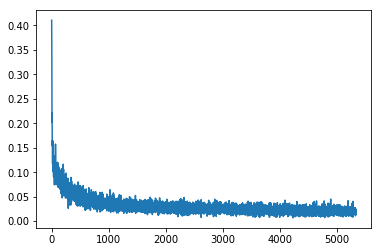

In [160]:
plt.plot(train_loss)

In [181]:
x, y = test_dataset[0]
print(x, y)

[ 0.67450115 -0.58776353  1.04708716  1.31648267] [1. 0. 0.]


In [163]:
y_pred = model(Variable(torch.Tensor(x)))

In [182]:
_, y_pred = torch.max(y_pred.view(-1, 1), 0)
print(y_pred)

tensor([0])


In [184]:
np.argmax(y)

0

In [185]:
print(model.parameters())
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

<generator object Module.parameters at 0x7f9a77aa0e08>
4
torch.Size([100, 4])
torch.Size([100])
torch.Size([3, 100])
torch.Size([3])
